In [ ]:
#改变当前工作目录到谷歌云盘的路径
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/Colab Notebooks/"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive/


['Untitled5.ipynb',
 'BRAIN-LARGE-scVI.ipynb',
 'BRAIN-SMALL.ipynb',
 'BRAIN-LARGE.ipynb',
 'Untitled (1)',
 'BRAIN-LARGE-prepro.ipynb',
 'learn_scanpy.ipynb',
 'Untitled0.ipynb',
 'scvi_RETINA.ipynb',
 '“preprocessing.ipynb”的副本',
 'Untitled1.ipynb',
 'scvi_CORTEX.ipynb',
 'reproduce_scvi_tutorial.ipynb',
 'scScope.ipynb',
 '“ae_mnist_conv_jax.ipynb”的副本 (1)',
 '“ae_mnist_conv_jax.ipynb”的副本',
 '““ae-dae_on_mnist”的副本”的副本',
 '“ae_dae_on_fashionmnist”的副本',
 'Untitled',
 'cauculate_p.ipynb',
 'Untitled2.ipynb',
 'Untitled3.ipynb',
 'self_ae.ipynb',
 'self_vae.ipynb',
 'data',
 'new_IS.ipynb',
 'IS.ipynb',
 'fashionmnist_images',
 'FID.ipynb',
 'FID_nb.ipynb',
 'my_vae.ipynb',
 'my_ae.ipynb',
 'my_sae.ipynb',
 'my_gan.ipynb',
 'my_dae.ipynb',
 'my_diffusion.ipynb']

In [ ]:
#加载相应包
! pip install denoising_diffusion_pytorch
!pip install memory_profiler
%load_ext memory_profiler

import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

#超参数设置
num_epoch = 10
lr = 5e-4
batch_size = 64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.0/912.0 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [ ]:
train_data = datasets.FashionMNIST(
  root = "data",
  train = True,
  transform = transforms.ToTensor(),
  download = True,
)

test_data = datasets.FashionMNIST(
  root = "data",
  train = False,
  transform = transforms.ToTensor(),
  download = True,
)

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [ ]:
#模型
model = Unet(
    dim = 64,
    channels = 1,
    dim_mults = (1, 2, 2)
)
model.to(device)
diffusion = GaussianDiffusion(
    model,
    objective = 'pred_noise',
    image_size = 28,
    timesteps = 500    # number of steps
)
diffusion.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
#训练
%%memit
for epoch in range(num_epoch):
  for step, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    images = images.to(device)
    loss = diffusion(images)

    loss.backward()
    optimizer.step()

  print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epoch, loss.item()))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Loss: 0.0803
Epoch [2/10], Loss: 0.0545
Epoch [3/10], Loss: 0.0635
Epoch [4/10], Loss: 0.0886
Epoch [5/10], Loss: 0.0707
Epoch [6/10], Loss: 0.0888
Epoch [7/10], Loss: 0.0635
Epoch [8/10], Loss: 0.0621
Epoch [9/10], Loss: 0.0519
Epoch [10/10], Loss: 0.0613
peak memory: 1399.59 MiB, increment: 590.13 MiB


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

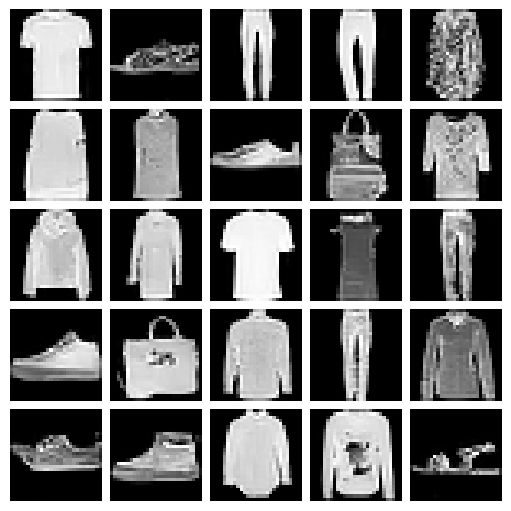

In [ ]:
# DDPM生成新数据图片
generated_images = diffusion.sample(batch_size=25)
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
gs = fig.add_gridspec(5, 5)

imgs = generated_images.reshape(5, 5, 28, 28).to('cpu')
for n_row in range(5):
    for n_col in range(5):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]), cmap="gray")
        f_ax.axis("off")


In [ ]:
#生成数据并下载
import os
from PIL import Image
import torch

directory = '/content/drive/My Drive/diffusion_fashionmnist_images/'
if not os.path.exists(directory):
    os.makedirs(directory)

num_samples = 1000

imgs = diffusion.sample(batch_size=num_samples).cpu().view(num_samples, 1, 28, 28)

for i, image in enumerate(imgs):
    image = image.squeeze(0)*255.0
    pil_image = Image.fromarray(image.cpu().numpy().astype(np.uint8)).convert('RGB')

    pil_image.save(f'/content/drive/My Drive/diffusion_fashionmnist_images/image_{i:05d}.png')

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]